# Event-Driven Simulation of M/M/1 Queues

We start with a single-server queue with a FIFO queuing discipline. For M/M/1 queue, the customer inter-arrival time and the service time are both exponentially distributed. There is only one server for the queue. When a customer arrives at the queue, he will find himself at the end of the queue, where he will wait until he gets to the front of the queue. He will enter service as soon as the server finishes with the previous customer. Then the customer will get served for some time and then leave the system. 

We use simulus to simulate this scenario. Let's start with the easy way using the event-driven approach, where we handle the customer arrival and departure events, since these are the only instances when the state the queue may change.

## Setup and Random Number Generator Functions

Before we start this section, let's first run the following so that we can set up the environment and import the necessary packages.

In [1]:
# for random distributions, random number generators, statistics
import random
import numpy as np
import scipy.stats as stats

# for simulation and for qmodels
import simulus, qmodels

# for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

You should have finished the previous section on random number generation for simulation. We pick up from there and first create a generator function to get the random numbers from an exponential distribution with a given mean. The random sequence will start with a given random seed.

In [2]:
def expon(mean, seed):
    rv = stats.expon(scale=mean)
    rv.random_state = np.random.RandomState(seed)
    while True:
        # 100 random numbers as a batch
        for x in rv.rvs(100):
            yield x

We can implement the same for other distributions.  

## Scheduling Event Handlers

When a customer arrives at the queue, two things happen. One is that we need to schedule the arrival of the next customer. The other is that we check whether the customer can be served immediately (that is, the customer is the only one in the system upon arrival). If so, we need to schedule the departure of this customer. 

In simulus, to schedule an event in the future, we use the simulator's `sched()`, which takes the name of a function (which we call the event handler), followed by the list of arguments to be passed to the event handler (we have none for this example). The 'offset' argument is a keyword argument for the `sched()` function (not for the event handler); it specifies the relative time from now the event is scheduled to happen.

The event handler for customer arrival is listed below. Note that we use a global varaible `num_in_system` to track the current number of customers in the system.

In [3]:
def arrive():
    global num_in_system
    print('%g: customer arrives (num_in_system=%d->%d)' %
          (sim.now, num_in_system, num_in_system+1))
    
    # increment the total number of customers in system
    num_in_system += 1
    
    # schedule next customer's arrival
    sim.sched(arrive, offset=next(inter_arrival_time))
    
    # the arrived customer is the only one in system
    if num_in_system == 1:
        # schedule the customer's departure
        sim.sched(depart, offset=next(service_time))

When a customer gets served, he leaves the system. After that, if there are other customers waiting, the next customer will be served immediately. For that, we need to schedule the departure of that customer. 

The event handler for customer departure is listed below:

In [4]:
def depart():
    global num_in_system
    print('%g: customer departs (num_in_system=%d->%d)' %
          (sim.now, num_in_system, num_in_system-1))
    
    # decrement the total number of customers in system
    num_in_system -= 1
    
    # there are remaining customers in system
    if num_in_system > 0:
        # schedule the next customer's departure
        sim.sched(depart, offset=next(service_time))

Now we are ready to simulate the queue. We instantiate a simulator. We then create two generators, one for the inter-arrival time and the other for the service time. The two generators use separate random streams, seeded from the simulator-specific random sequence. Before we start the simulation, we schedule the first customer's arrival. And finally we run the simulation for 10 simulated seconds.

In [5]:
random.seed(13579) # global random seed

sim = simulus.simulator('mm1')
inter_arrival_time = expon(1.2, sim.rng().randrange(2**32))
service_time = expon(0.8, sim.rng().randrange(2**32))

num_in_system = 0
sim.sched(arrive, offset=next(inter_arrival_time))
sim.run(10)

0.117886: customer arrives (num_in_system=0->1)
0.440574: customer departs (num_in_system=1->0)
0.442274: customer arrives (num_in_system=0->1)
1.34061: customer departs (num_in_system=1->0)
1.4955: customer arrives (num_in_system=0->1)
1.59616: customer departs (num_in_system=1->0)
1.78134: customer arrives (num_in_system=0->1)
2.09363: customer arrives (num_in_system=1->2)
2.50151: customer departs (num_in_system=2->1)
2.63192: customer departs (num_in_system=1->0)
6.51199: customer arrives (num_in_system=0->1)
7.05751: customer arrives (num_in_system=1->2)
7.32092: customer departs (num_in_system=2->1)
8.02589: customer arrives (num_in_system=1->2)
8.05119: customer arrives (num_in_system=2->3)
8.95281: customer arrives (num_in_system=3->4)
9.55017: customer departs (num_in_system=4->3)
9.5674: customer departs (num_in_system=3->2)


## Statistics Collection and Plotting

The output from the previous simulation is kind of boring. Let's gather some statistics and try to plot them. 

We want to collect the wait time of the customers. To do that, we need to remember the time when the customer arrives at the system and also the time when the customer departs from the system. There are many ways to do the bookkeeping, the easy way we found is to simply use a data structure to keep track of the waiting customers. We use a deque (double-ended queue). We insert the time at which a customer enters the system and remove a time when the customer leaves. The time in-between is the customers wait time (including both queuing time and time in service). 

We also want to track the number of customers in the system as it changes over time. For this, we use a list and each entry in the list is a tuple consisted of the time and the number of customers enqueued at the time.

The event handlers revised with bookkeeping are listed below:

In [6]:
from collections import deque

def arrive():
    # add the customer to the end of the queue
    queue.append(sim.now)
    in_systems.append((sim.now, len(queue)))
    
    # schedule next customer's arrival
    sim.sched(arrive, offset=next(inter_arrival_time))
    
    # the arrived customer is the only one in system
    if len(queue) == 1:
        # schedule the customer's departure
        sim.sched(depart, offset=next(service_time))
        
def depart():
    # remove a customer from the head of the queue
    t = queue.popleft()
    in_systems.append((sim.now, len(queue)))
    waits.append(sim.now-t)
    
    # there are remaining customers in system
    if len(queue) > 0:
        # schedule the next customer's departure
        sim.sched(depart, offset=next(service_time))

Now we can run the simulation to gather the statistics. We can calculate the sample mean and standard deviation of the wait time. We can also calculate the (time-weighted) average number of customers in the system. If one plots the number of customers in system over time (which is a step function), it's the area under the curve divided by time.

In [7]:
queue = deque()
in_systems = [(0,0)]
waits = []

sim = simulus.simulator('mm1')
inter_arrival_time = expon(1.2, sim.rng().randrange(2**32))
service_time = expon(0.8, sim.rng().randrange(2**32))
sim.sched(arrive, offset=next(inter_arrival_time))
sim.run(10000)

print('wait times: %r...' % waits[:3])
print('number customers in systems: %r...' % in_systems[:3])

waits = np.array(waits)
print("wait time: mean=%g, stdev=%g" % 
      (waits.mean(), waits.std()))

# area under curve divided by time is the 
# average number of customers in system
auc, last_t, last_l = 0, 0, 0
for t, l in in_systems:
    auc += (t-last_t)*last_l
    last_t, last_l = t, l
print("avg number of customers in system = %g" % (auc/last_t))

wait times: [0.32268893720840264, 0.8983373047687732, 0.10065541473146267]...
number customers in systems: [(0, 0), (0.1178855329607668, 1), (0.44057447016916945, 0)]...
wait time: mean=2.39855, stdev=2.34153
avg number of customers in system = 2.00328


The queuing theory for M/M/1 queue tells us that in steady state, the mean wait time should be $1/(\mu - \lambda)$ and the mean number of customers in system should be $\lambda/(\mu - \lambda)$. That is, $\lambda=1/1.2=5/6$ and $\mu=1/0.8=5/4$. Therefore, the mean wait time should be 2.4, and the mean number of customers in system should be 2.0. We can use long-run simulation to obtain better steady-state estimations. But in most simulation cases, we'd be more interested in the transient behaviors of the system under study.  

The data collected during simulation can also be used to generate many interesting plots. For example, we can plot the number of customers in the system as it changes over time. In the following, we only plot the first few.

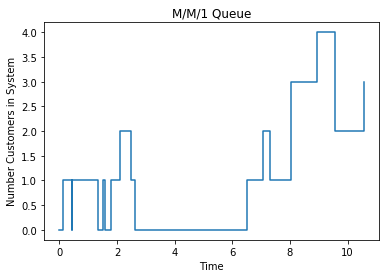

In [8]:
plt.step(*zip(*in_systems[:20]), where='post')
plt.title("M/M/1 Queue")
plt.xlabel("Time")
plt.ylabel("Number Customers in System")
plt.show()

We can plot histogram of the wait time. And we can examine the percentage of customers who have experienced long wait time, say, more than 10 seconds. 

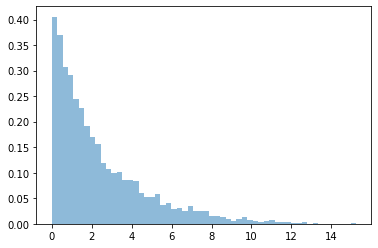

1.22156% customers experienced wait time more than 10 seconds,
while 90% of customers experienced wait time no more than 5.71846 seconds


In [9]:
plt.hist(waits, alpha=0.5, bins='auto', density=True)
plt.show()
print('%g%% customers experienced wait time more than 10 seconds,' % 
      (100*(waits>10).sum()/len(waits)))
print('while 90%% of customers experienced wait time no more than %g seconds' % 
      np.percentile(waits, 90))

The above plot shows that the mean wait time increases as we increase 'b', which increases both the mean and the standard deviation of the service time. The confidence interval also seems to be getting larger as we increase 'b'. 

As 'b' increases, the service rate decreases and the difference between the arrival rate and service rate decreases as a result. It takes longer for the simulation to reach steady state. We fixed each simulation run to last for 1000 simulated seconds, which may not be sufficient for a larger 'b'.

## Source Code

The following is the source code for the event-driven M/M/1 model. To make the code more organized and reusable, we wrap the variables and both `arrive` and `depart` methods inside the class `mm1`. We also use Python's logging module to provide user with the option to turn printing on and off.

In [10]:
# %load '../qmodels/mm1.py'
import random, logging
from collections import deque
import numpy as np
import scipy.stats as stats
import simulus

from qmodels.rng import *

__all__ = ['mm1']

class mm1(object):
    def __init__(self, sim, mean_iat, mean_svtime):
        self.sim = sim

        self.inter_arrival_time = expon(mean_iat, sim.rng().randrange(2**32))
        self.service_time = expon(mean_svtime, sim.rng().randrange(2**32))

        self.queue = deque()
        self.in_systems = [(0,0)]
        self.waits = []

        self.logger = logging.getLogger('mm1')
        handler = logging.StreamHandler()
        handler.setFormatter(logging.Formatter('%(name)s: %(levelname)s: %(message)s'))
        self.logger.addHandler(handler)

        sim.sched(self.arrive, offset=next(self.inter_arrival_time))

    def arrive(self):
        '''Event handler for customer arrival.'''
        self.logger.info('%g: customer arrives (num_in_system=%d->%d)' %
                         (sim.now, len(self.queue), len(self.queue)+1))

        # add the customer to the end of the queue
        self.queue.append(self.sim.now)
        self.in_systems.append((self.sim.now, len(self.queue)))
    
        # schedule next customer's arrival
        self.sim.sched(self.arrive, offset=next(self.inter_arrival_time))
    
        # the arrived customer is the only one in system
        if len(self.queue) == 1:
            # schedule the customer's departure
            self.sim.sched(self.depart, offset=next(self.service_time))
        
    def depart(self):
        '''Event handler for customer departure.'''
        self.logger.info('%g: customer departs (num_in_system=%d->%d)' %
                         (sim.now, len(self.queue), len(self.queue)-1))

        # remove a customer from the head of the queue
        t = self.queue.popleft()
        self.in_systems.append((self.sim.now, len(self.queue)))
        self.waits.append(self.sim.now-t)
    
        # there are remaining customers in system
        if len(self.queue) > 0:
            # schedule the next customer's departure
            self.sim.sched(self.depart, offset=next(self.service_time))

if __name__ == '__main__':
    random.seed(13579) # global random seed
    sim = simulus.simulator('mm1') # create a simulator instance
    q = mm1(sim, 1.2, 0.8) # create the m/m/1 queue
    q.logger.setLevel(logging.INFO)
    sim.run(10)


mm1: INFO: 0.117886: customer arrives (num_in_system=0->1)
mm1: INFO: 0.440574: customer departs (num_in_system=1->0)
mm1: INFO: 0.442274: customer arrives (num_in_system=0->1)
mm1: INFO: 1.34061: customer departs (num_in_system=1->0)
mm1: INFO: 1.4955: customer arrives (num_in_system=0->1)
mm1: INFO: 1.59616: customer departs (num_in_system=1->0)
mm1: INFO: 1.78134: customer arrives (num_in_system=0->1)
mm1: INFO: 2.09363: customer arrives (num_in_system=1->2)
mm1: INFO: 2.50151: customer departs (num_in_system=2->1)
mm1: INFO: 2.63192: customer departs (num_in_system=1->0)
mm1: INFO: 6.51199: customer arrives (num_in_system=0->1)
mm1: INFO: 7.05751: customer arrives (num_in_system=1->2)
mm1: INFO: 7.32092: customer departs (num_in_system=2->1)
mm1: INFO: 8.02589: customer arrives (num_in_system=1->2)
mm1: INFO: 8.05119: customer arrives (num_in_system=2->3)
mm1: INFO: 8.95281: customer arrives (num_in_system=3->4)
mm1: INFO: 9.55017: customer departs (num_in_system=4->3)
mm1: INFO: 9